# Thư viện

In [9]:
import pandas as pd
import os
from random import randint
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Dictionary cho nhãn

In [2]:
labels_dict = {'Basophil': 0, 'Eosinophil': 1, 'Lymphocyte': 2, 'Monocyte': 3, 'Neutrophil': 4}
classes = list(labels_dict.keys())

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.applications.inception_v3 import InceptionV3
from keras.layers import Input, Dropout, Dense, GlobalAveragePooling2D, BatchNormalization
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.models import Model
from tensorflow.keras import regularizers
from keras.initializers import glorot_uniform
from sklearn.utils.class_weight import compute_class_weight


# Cấu hình tham số cơ bản

In [3]:
BATCH_SIZE = 32
IMAGE_SIZE = 299

# Tạo ImageDataGenerator

In [4]:
data_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,         # Thêm xoay ảnh ngẫu nhiên trong khoảng ±20 độ
    width_shift_range=0.1,     # Tăng range shift lên 0.1
    height_shift_range=0.1,    # Tăng range shift lên 0.1
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.2,          # Thêm zoom ngẫu nhiên ±15%
    shear_range=0.2,         # Thêm biến dạng hình ảnh
    brightness_range=[0.8, 1.2],  # Thêm điều chỉnh độ sáng
    fill_mode='nearest',       # Xử lý pixels mới sau khi biến đổi
    validation_split=0.3,
    channel_shift_range=50.0
)

# Khởi tạo dữ liệu training và validation

In [5]:
train_data = data_gen.flow_from_directory(
    directory='Train',
    subset='training',
    batch_size=BATCH_SIZE,
    shuffle=True,
    class_mode='categorical',
    target_size=(IMAGE_SIZE, IMAGE_SIZE)
)

valid_data = data_gen.flow_from_directory(
    directory='Train',
    subset='validation',
    batch_size=BATCH_SIZE,
    shuffle=False,
    class_mode='categorical',
    target_size=(IMAGE_SIZE, IMAGE_SIZE)
)

Found 7124 images belonging to 5 classes.
Found 3051 images belonging to 5 classes.


# Dữ liệu test

In [6]:
test_data = ImageDataGenerator(rescale=1./255).flow_from_directory(
    directory='Test',
    batch_size=BATCH_SIZE,
    shuffle=False,
    class_mode='categorical',
    target_size=(IMAGE_SIZE, IMAGE_SIZE)
)

Found 4339 images belonging to 5 classes.


# Hiển thị ảnh mẫu

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8509804..0.92156863].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9843137..0.5294118].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.75686276..0.5294118].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9764706..0.73333335].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7176471..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9607843..0.54509807].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.4980392.

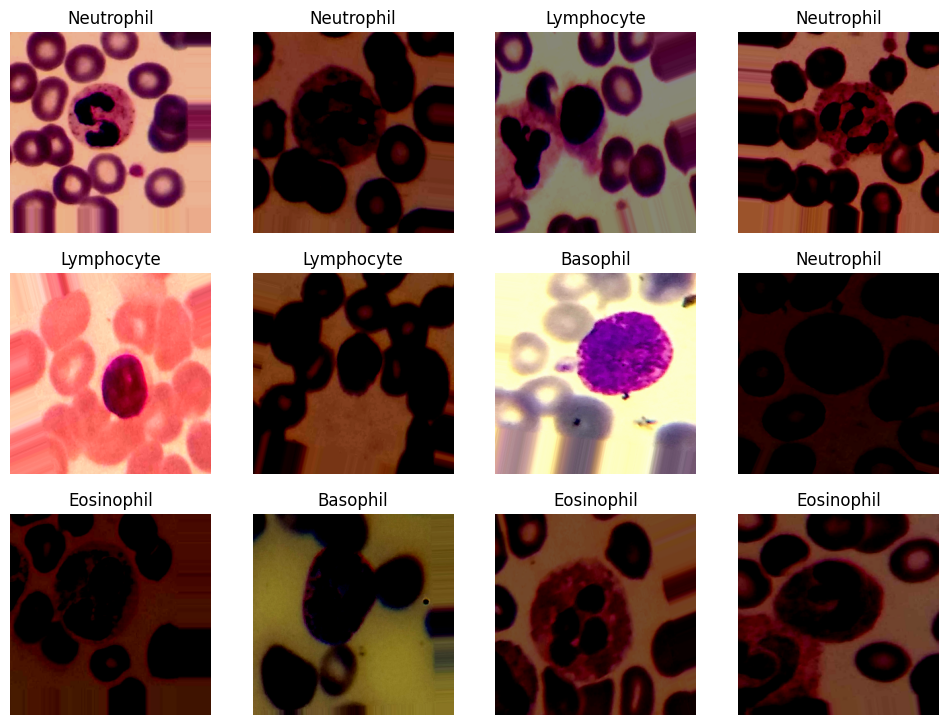

In [10]:
image, label = next(train_data)
plt.figure(figsize=(12, 12))
for i in range(12):
    plt.subplot(4, 4, i+1)
    plt.imshow(image[i])
    plt.title(classes[np.argmax(label[i])])
    plt.axis('off')
plt.show()

# Tính class weights

In [11]:
classes_array = train_data.classes
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(classes_array),
    y=classes_array
)
class_weight_dict = dict(enumerate(class_weights))

# Tạo generator tùy chỉnh

In [12]:
def custom_data_generator(data_gen, class_weight_dict):
    while True:
        X_batch, y_batch = next(data_gen)
        sample_weights = np.array([class_weight_dict[np.argmax(label)] for label in y_batch])
        yield X_batch, y_batch, sample_weights

train_data_gen = custom_data_generator(train_data, class_weight_dict)


# Khởi tạo mô hình với InceptionV3

In [13]:
net = InceptionV3(include_top=False, weights='imagenet', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
net.trainable = False

# Thêm các lớp phía trên

In [14]:
x = net.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.0005))(x)
x = Dropout(0.5)(x)
x = Dense(5, activation='softmax',
          kernel_initializer=glorot_uniform(),
          kernel_regularizer=regularizers.l2(0.001))(x)


# Kết nối lại mô hình

In [15]:
model = Model(inputs=net.input, outputs=x)

# Cấu hình optimizer và compile mô hình

In [16]:
adam = tf.keras.optimizers.Adam(learning_rate=2e-4)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

# Callback cho training

In [17]:
ES = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=8, mode='min', restore_best_weights=True, verbose=1)
RL = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, verbose=1, mode='min', min_lr=1e-7)
callbacks = [ES, RL]

# Huấn luyện lần 1

In [16]:
steps_per_epoch = np.ceil(len(train_data.filenames) / BATCH_SIZE).astype(int)
validation_steps = np.ceil(len(valid_data.filenames) / BATCH_SIZE).astype(int)

history1 = model.fit(
    train_data_gen,
    validation_data=valid_data,
    epochs=50,  # Số epochs cho giai đoạn 1
    callbacks=callbacks,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps
)

Epoch 1/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4336 - loss: 1.6878

c:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


223/223 ━━━━━━━━━━━━━━━━━━━━ 523s 2s/step - accuracy: 0.4343 - loss: 1.6860 - val_accuracy: 0.7342 - val_loss: 0.9862 - learning_rate: 2.0000e-04
Epoch 2/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 473s 2s/step - accuracy: 0.7624 - loss: 0.8457 - val_accuracy: 0.7388 - val_loss: 1.0097 - learning_rate: 2.0000e-04
Epoch 3/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 480s 2s/step - accuracy: 0.7923 - loss: 0.7718 - val_accuracy: 0.7493 - val_loss: 0.9920 - learning_rate: 2.0000e-04
Epoch 4/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 526s 2s/step - accuracy: 0.8235 - loss: 0.6762 - val_accuracy: 0.7434 - val_loss: 1.0261 - learning_rate: 2.0000e-04
Epoch 5/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 482s 2s/step - accuracy: 0.8292 - loss: 0.6368 - val_accuracy: 0.7778 - val_loss: 0.9260 - learning_rate: 2.0000e-04
Epoch 6/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 473s 2s/step - accuracy: 0.8551 - loss: 0.6215 - val_accuracy: 0.7856 - val_loss: 0.9147 - learning_rate: 2.0000e-04
Epoch 7/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 458s 2s/step - accuracy: 0.85

# Fine-tuning

In [18]:
net.trainable = True
for layer in net.layers[:-20]:
    layer.trainable = False

# Giảm learning rate để fine-tune

In [19]:
adam_finetune = tf.keras.optimizers.Adam(learning_rate=1e-5)  
model.compile(optimizer=adam_finetune, loss='categorical_crossentropy', metrics=['accuracy'])

# Callback cho fine-tuning

In [20]:
ES_finetune = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=10, 
                            mode='min', restore_best_weights=True, verbose=1)
RL_finetune = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, 
                                verbose=1, mode='min', min_lr=1e-7)
callbacks_finetune = [ES_finetune, RL_finetune]

# Huấn luyện lần 2 (fine-tune)

In [25]:
history2 = model.fit(
    train_data,
    validation_data=valid_data,
    epochs=50,
    callbacks=callbacks_finetune,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    class_weight=class_weight_dict
)

NameError: name 'steps_per_epoch' is not defined

# Hiển thị lịch sử huấn luyện

In [26]:
plt.plot(history1.history['accuracy'], label='Training Accuracy Phase 1')
plt.plot(history1.history['val_accuracy'], label='Validation Accuracy Phase 1')
plt.plot(history2.history['accuracy'], label='Training Accuracy Phase 2')
plt.plot(history2.history['val_accuracy'], label='Validation Accuracy Phase 2')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

NameError: name 'history1' is not defined